In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
csv_file_path = r"D:\KOI_cumulative_2025.09.21_07.29.50.csv"
data = pd.read_csv(csv_file_path, skiprows=53)
#print(data.info())
print(data.head())

      kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2  10811496  K00753.01           NaN       CANDIDATE        CANDIDATE   
3  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  ...  \
0      1.000              0              0              0              0  ...   
1      0.969              0              0              0              0  ...   
2      0.000              0              0              0              0  ...   
3      0.000              0              1              0              0  ...   
4      1.000              0              0              0              0  ...   

   koi_steff_err2  koi_slogg  koi_slogg_err1  koi_slogg_err2  koi_srad  \


In [2]:
target = "koi_disposition"  # define your target column

# Step 1: Drop ID/leakage columns
drop_cols = ["kepid", "kepoi_name", "kepler_name", "koi_pdisposition"]
data_clean = data.drop(columns=drop_cols)

# Step 2: Drop columns with >30% missing
threshold = 0.3 * len(data_clean)
data_clean = data_clean.dropna(axis=1, thresh=threshold)

# Step 3: Fill missing numeric values with median
for col in data_clean.select_dtypes(include=[np.number]).columns:
    data_clean[col] = data_clean[col].fillna(data_clean[col].median())

# Step 4: Binary target mapping
data_clean[target] = data_clean[target].map({
    "CONFIRMED": 1,
    "FALSE POSITIVE": 0,
    "CANDIDATE": 0
})

# Step 5: Split features and target
X = data_clean.drop(columns=[target])
y = data_clean[target]

# Step 6: Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ Final check
print("✅ Data Cleaning Done")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Target distribution (train):")
print(y_train.value_counts(normalize=True))
print("Target distribution (test):")
print(y_test.value_counts(normalize=True))


   

✅ Data Cleaning Done
Train shape: (7651, 42)
Test shape: (1913, 42)
Target distribution (train):
koi_disposition
0    0.712848
1    0.287152
Name: proportion, dtype: float64
Target distribution (test):
koi_disposition
0    0.713016
1    0.286984
Name: proportion, dtype: float64


In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in X_train.select_dtypes(include=["object"]).columns:
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))


C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:15:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Accuracy: 0.9472033455305803
              precision    recall  f1-score   support

  Not Planet       0.97      0.96      0.96      1364
      Planet       0.90      0.92      0.91       549

    accuracy                           0.95      1913
   macro avg       0.93      0.94      0.94      1913
weighted avg       0.95      0.95      0.95      1913

ROC-AUC: 0.9840445705067599


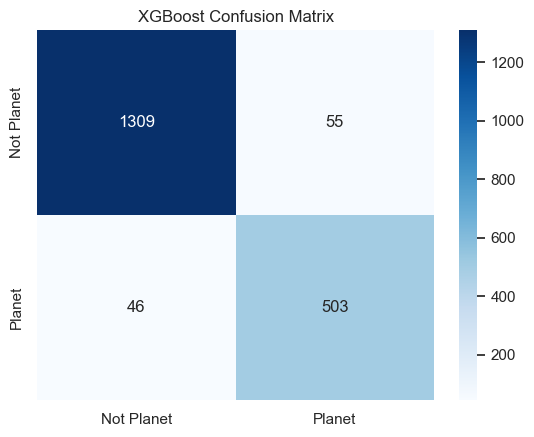

In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# 🔥 XGBoost Classifier
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])  # handle imbalance
)

# Train
xgb.fit(X_train, y_train)

# Predictions
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("✅ XGBoost Accuracy:", acc)

# Other metrics
print(classification_report(y_test, y_pred, target_names=["Not Planet", "Planet"]))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Planet", "Planet"],
            yticklabels=["Not Planet", "Planet"])
plt.title("XGBoost Confusion Matrix")
plt.show()


In [5]:
import pickle

# Save model
with open("model.pkl", "wb") as file:
    pickle.dump(xgb, file)

print("✅ Model saved as model.pkl")

# Load model back
with open("model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

# Test loaded model
y_pred_loaded = loaded_model.predict(X_test)
print("Loaded model accuracy:", accuracy_score(y_test, y_pred_loaded))


✅ Model saved as model.pkl
Loaded model accuracy: 0.9472033455305803


In [6]:
import joblib
from sklearn.preprocessing import LabelEncoder

# Save medians for numeric columns
numeric_cols = X_train.select_dtypes(include=['number']).columns
medians = X_train[numeric_cols].median().to_dict()
joblib.dump(medians, "medians.pkl")

# Save label encoders for categorical columns
le_dict = {}
for col in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    le.fit(X_train[col].astype(str))
    le_dict[col] = le
joblib.dump(le_dict, "label_encoders.pkl")


['label_encoders.pkl']

In [7]:
import streamlit as st
import pandas as pd
import pickle
import joblib

# ---------- Load model and preprocessing ----------
with open(r"C:\Users\LENOVO\Desktop\Nasaproject\model.pkl", "rb") as f:
    model = pickle.load(f)

medians = joblib.load(r"C:\Users\LENOVO\Desktop\Nasaproject\medians.pkl")
le_dict = joblib.load(r"C:\Users\LENOVO\Desktop\Nasaproject\label_encoders.pkl")

st.title("Exoplanet Prediction 🚀")
st.write("Input the KOI features to predict if it is a confirmed exoplanet.")

# ---------- Feature names ----------
feature_names = model.get_booster().feature_names  # all features used in training

# ---------- Friendly display names ----------
# Fill in all your column names here. Example below for common ones:
feature_display_names = {
    "kepid": "KepID",
    "kepoi_name": "KOI Name",
    "kepler_name": "Kepler Name",
    "koi_disposition": "Exoplanet Archive Disposition",
    "koi_pdisposition": "Disposition Using Kepler Data",
    "koi_score": "Disposition Score",
    "koi_fpflag_nt": "Not Transit-Like False Positive Flag",
    "koi_fpflag_ss": "Stellar Eclipse False Positive Flag",
    "koi_fpflag_co": "Centroid Offset False Positive Flag",
    "koi_fpflag_ec": "Ephemeris Contamination False Positive Flag",
    "koi_period": "Orbital Period [days]",
    "koi_period_err1": "Orbital Period Upper Unc. [days]",
    "koi_period_err2": "Orbital Period Lower Unc. [days]",
    "koi_time0bk": "Transit Epoch [BKJD]",
    "koi_time0bk_err1": "Transit Epoch Upper Unc. [BKJD]",
    "koi_time0bk_err2": "Transit Epoch Lower Unc. [BKJD]",
    "koi_impact": "Impact Parameter",
    "koi_impact_err1": "Impact Parameter Upper Unc.",
    "koi_impact_err2": "Impact Parameter Lower Unc.",
    "koi_duration": "Transit Duration [hrs]",
    "koi_duration_err1": "Transit Duration Upper Unc. [hrs]",
    "koi_duration_err2": "Transit Duration Lower Unc. [hrs]",
    "koi_depth": "Transit Depth [ppm]",
    "koi_depth_err1": "Transit Depth Upper Unc. [ppm]",
    "koi_depth_err2": "Transit Depth Lower Unc. [ppm]",
    "koi_prad": "Planetary Radius [Earth radii]",
    "koi_prad_err1": "Planetary Radius Upper Unc. [Earth radii]",
    "koi_prad_err2": "Planetary Radius Lower Unc. [Earth radii]",
    "koi_teq": "Equilibrium Temperature [K]",
    "koi_teq_err1": "Equilibrium Temperature Upper Unc. [K]",
    "koi_teq_err2": "Equilibrium Temperature Lower Unc. [K]",
    "koi_insol": "Insolation Flux [Earth flux]",
    "koi_insol_err1": "Insolation Flux Upper Unc. [Earth flux]",
    "koi_insol_err2": "Insolation Flux Lower Unc. [Earth flux]",
    "koi_model_snr": "Transit Signal-to-Noise",
    "koi_tce_plnt_num": "TCE Planet Number",
    "koi_tce_delivname": "TCE Delivery",
    "koi_steff": "Stellar Effective Temperature [K]",
    "koi_steff_err1": "Stellar Effective Temperature Upper Unc. [K]",
    "koi_steff_err2": "Stellar Effective Temperature Lower Unc. [K]",
    "koi_slogg": "Stellar Surface Gravity [log10(cm/s^2)]",
    "koi_slogg_err1": "Stellar Surface Gravity Upper Unc. [log10(cm/s^2)]",
    "koi_slogg_err2": "Stellar Surface Gravity Lower Unc. [log10(cm/s^2)]",
    "koi_srad": "Stellar Radius [Solar radii]",
    "koi_srad_err1": "Stellar Radius Upper Unc. [Solar radii]",
    "koi_srad_err2": "Stellar Radius Lower Unc. [Solar radii]",
    "ra": "RA [decimal degrees]",
    "dec": "Dec [decimal degrees]",
    "koi_kepmag": "Kepler-band [mag]"
}

# ---------- Collect user input ----------
user_input = {}
for feature in feature_names:
    display_name = feature_display_names.get(feature, feature)  # fallback to column name
    if feature in le_dict:
        user_input[feature] = st.text_input(f"{display_name} (categorical)")
    else:
        user_input[feature] = st.number_input(f"{display_name}", value=medians.get(feature, 0.0))

input_df = pd.DataFrame([user_input])

# ---------- Preprocessing ----------
# Label encode categorical inputs
for col in le_dict:
    if col in input_df.columns:
        input_df[col] = le_dict[col].transform(input_df[col].astype(str))

# Fill numeric missing values
for col in medians:
    if col in input_df.columns:
        input_df[col] = input_df[col].fillna(medians[col])

# ---------- Prediction ----------
if st.button("Predict"):
    prediction = model.predict(input_df)[0]
    proba = model.predict_proba(input_df)[0][1]

    if prediction == 1:
        st.success(f"This KOI is predicted to be an EXOPLANET! 🌟 (Confidence: {proba:.2f})")
    else:
        st.warning(f"This KOI is predicted to be NOT an EXOPLANET. (Confidence: {1-proba:.2f})")


2025-09-25 20:15:19.510 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 20:15:20.243 
  command:

    streamlit run C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-25 20:15:20.244 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 20:15:20.245 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 20:15:20.246 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 20:15:20.246 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 20:15:20.247 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-25 20:15:20.249 Thr

In [ ]:
!streamlit run "C:\Users\LENOVO\Desktop\Nasaproject\app2.py"
